In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

On September 17, 2019, the overnight repo rate spiked to nearly 10%—the highest since the financial crisis. This case study walks through the mechanics of the Treasury basis trade during this episode, asking you to:

1. Calculate forward prices, implied repo rates, and net basis before the crisis
2. Analyze how the basis trade P&L evolved as repo rates spiked
3. Evaluate dynamic trading strategies in hindsight

Unlike the March 2020 COVID crisis, the September 2019 repo spike was short-lived—the Fed intervened within days and markets normalized. This provides a useful contrast for understanding how different types of market stress affect basis trade P&L.

In [2]:
file = "fut_bond_data_TYZ9_2019-09.xlsx"
futures_df = pd.read_excel(file, sheet_name='future').set_index('field')
bonds_df = pd.read_excel(file, sheet_name='bonds').set_index('ticker')
daily_df = pd.read_excel(file, sheet_name='daily', index_col=0, parse_dates=True)

In [3]:
# Key parameters
FACE = 100
DAYS_SETTLE = 1  # T+1 settlement
DAYS_TBILL_DENOM = 360  # ACT/360 convention

In [4]:
futures_date = pd.to_datetime('2019-09-13')
settle_date = futures_date + pd.Timedelta(days=DAYS_SETTLE)
expiration_date = futures_date + pd.Timedelta(days=109)

# 2. Setting Up the Trade (September 13, 2019)

### 2.1 Calculate the Forward Price

Using the CTD bond data and the repo rate, calculate the forward price for delivery at the futures expiration.

Forward Price = Futures Price * Conversion Factor

In [5]:
futures_px_last = 128.578125
forward_price = futures_px_last * 0.7807
forward_price

100.3809421875

Dirty Price and Finance Period of 106 Days

In [6]:
bonds_df['px_dirty'] = bonds_df['px_last'] + bonds_df['accrued_interest']
bonds_df['days_to_delivery'] = 106

Repo Cost

In [7]:
bonds_df['repo_cost'] = (bonds_df['px_dirty'] * (bonds_df['repo_rate']/100) * (bonds_df['days_to_delivery']/ DAYS_TBILL_DENOM))
bonds_df['coupon_income'] = bonds_df['cpn']/bonds_df['cpn_freq']

Putting it all together

In [8]:
bonds_df['forward_dirty'] = bonds_df['px_dirty'] + bonds_df['repo_cost'] - bonds_df['coupon_income']
bonds_df['futures'] = bonds_df['forward_dirty']/bonds_df['conversion']

2.2 Calculate the Implied Repo Rate

Given the futures price, calculate the implied repo rate. Compare it to the actual repo rate.

In [9]:
bonds_df['market_forward_dirty'] = (futures_px_last * bonds_df['conversion']) + bonds_df['accrued_interest'] 
bonds_df['carry'] = (bonds_df['coupon_income'] - bonds_df['repo_cost'])
bonds_df['net_basis'] = bonds_df['gross_basis'] - bonds_df['carry']

bonds_df['implied_repo'] = (
    (bonds_df['market_forward_dirty'] - bonds_df['px_dirty'] + bonds_df['coupon_income']) / 
    bonds_df['px_dirty']
) * (DAYS_TBILL_DENOM / bonds_df['days_to_delivery']) * 100

bonds_df['repo_diff'] = bonds_df['implied_repo'] - bonds_df['repo_rate']

In [10]:
bonds_df[['implied_repo', 'repo_rate', 'gross_basis', 'repo_diff', 'net_basis']].round(4).head()

,implied_repo,repo_rate,gross_basis,repo_diff,net_basis
ticker,,,,,
9128287B Govt,3.4583,2.2,-0.0841,1.2583,-0.3717
912828Y9 Govt,3.4586,2.2,-0.0841,1.2586,-0.3718
9128282A Govt,2.4506,2.2,0.0422,0.2506,-0.0724
912828YD Govt,2.1871,2.2,0.0627,-0.0129,0.0037
912828U2 Govt,0.8402,2.2,0.7491,-1.3598,0.4060


In [11]:
ctd_implied_repo = 3.4583
actual_repo = 2.2
print(f"Implied Repo: {ctd_implied_repo:.2f}%")
print(f"Actual Repo: {actual_repo}%")
print(f"Difference: {ctd_implied_repo - actual_repo:.2f}%")

Implied Repo: 3.46%
Actual Repo: 2.2%
Difference: 1.26%


The implied repo rate for the CTD is 3.46% against the stated 2.2%. We would expect this bond to have the lowest gross basis, which it does. The net basis takes into account carry, but should give similar conclusions. 

The implied repo rate > actual repo rate suggests this earns excess returns.

2.3 Calculate Gross Basis, Carry, and Net Basis

Calculate the basis components for the CTD bond.

In [ ]:
ctd_bond = bonds_df.loc[bonds_df['name'] == 'T 1 7/8 06/30/26']

ctd_bond[['gross_basis', 'carry','net_basis']].round(4)

,gross_basis,carry,net_basis
ticker,,,
9128287B Govt,-0.0841,0.2876,-0.3717


Net basis here is more negative, which is a result of carry being positive and being taken out of gross basis. 

This means that cash bond is cheap. The trade would suggest buying the bond and selling the future

# 3. The Blowup (September 16-19, 2019)

On September 16, 2019, repo rates began spiking. By the morning of September 17, overnight repo hit 10%—more than 4x the Fed's target rate. The cause: a confluence of quarterly corporate tax payments, Treasury settlement, and reserves having fallen to "scarcity" levels.

The Fed responded immediately with overnight repo operations (the first since 2008), injecting liquidity. By September 19, rates had normalized.

Compare the carry and net basis on September 13 (pre-crisis) vs September 17 (peak crisis).

In [13]:
# spike_factor = 3
# bonds_df['peak_repo_cost'] = (bonds_df['px_dirty'] * (bonds_df['repo_rate']*spike_factor/100) * (105/ DAYS_TBILL_DENOM))
# bonds_df['peak_carry'] = (bonds_df['coupon_income'] - bonds_df['peak_repo_cost'])
# bonds_df['peak_gross_basis'] = (bonds_df['px_dirty'] - bonds_df['peak_repo_cost'] - bonds_df['market_forward_dirty'])
# bonds_df['peak_net_basis'] = bonds_df['peak_gross_basis'] - bonds_df['peak_carry']

In [ ]:
daily_df['carry'] = daily_df['gross_basis_32nds'] - daily_df['net_basis_32nds']

In [ ]:
crisis_delta_carry = float(daily_df.loc['2019-09-16']['carry'] - daily_df.loc['2019-09-13']['carry'])
crisis_delta_net_basis = float(daily_df.loc['2019-09-16']['net_basis_32nds'] - daily_df.loc['2019-09-13']['net_basis_32nds'])
crisis_delta_carry, crisis_delta_net_basis

(-0.6455000000000002, 0.5439999999999998)

### 3.1 Impact of Repo Spike on Carry and Net Basis

Compare the carry and net basis on September 13 (pre-crisis) vs September 17 (peak crisis).
When repo rates spike, what happens to:

Carry?
    It should fall. Carry takes out the repo rate. If this rate spikes, then the carry should be dragged down further. 

Net basis?
    Net Basis = Gross basis - Carry. Here, carry should become smaller or even more negative, which would cause net basis to rise. However, this is partially offset by the fall in gross basis. In any event, it should rise.

A basis trader’s P&L? 
    Well, we were long basis and basis has widened by 0.54, so we have done well

In [ ]:
NOTIONAL = 100_000_000
EQUITYCAPITAL = 2_000_000
leverage = NOTIONAL / EQUITYCAPITAL    
filtered_daily_df = daily_df.loc['2019-09-13':'2019-09-30']
filtered_daily_df['daily_pnl'] = (filtered_daily_df['net_basis_32nds'].diff().fillna(0)) * (NOTIONAL / 3200)
filtered_daily_df['cumulative_pnl'] = filtered_daily_df['daily_pnl'].cumsum()
filtered_daily_df.head()

,fut_price,ctd_price,net_basis_32nds,gross_basis_32nds,sofr,carry,daily_pnl,cumulative_pnl
date,,,,,,,,
2019-09-13,128.578125,100.296875,1.1908,-2.6887,2.20,-3.8795,0.000,0.000
2019-09-16,129.062500,100.625000,1.7348,-2.7902,2.43,-4.5250,17000.000,17000.000
2019-09-17,129.281250,100.875000,6.0704,-3.2579,5.25,-9.3283,135487.500,152487.500
2019-09-18,129.390625,100.796875,1.9443,-2.4877,2.55,-4.4320,-128940.625,23546.875
2019-09-19,129.593750,100.945312,-2.7552,-4.0633,1.95,-1.3081,-146859.375,-123312.500


<Axes: title={'center': 'Cumulative PnL'}, xlabel='Date', ylabel='Cumulative PnL ($)'>

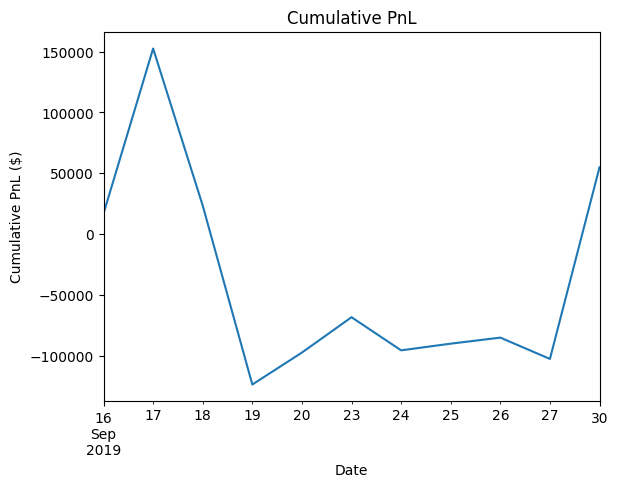

In [ ]:
filtered_daily_df['cumulative_pnl'][1:].plot(title='Cumulative PnL', ylabel='Cumulative PnL ($)', xlabel='Date')

After the initial drawdown the position recovered where it even ends positive on September 30th.

In [ ]:
max_drawdown = filtered_daily_df['cumulative_pnl'].cummax() - filtered_daily_df['cumulative_pnl']
max_drawdown.max()

np.float64(275800.0)

The max drawdown would be from Sep. 17th to Sep 19th, where the cumulative PnL fell by 275,800. It would be worst at the end of this range, Sep 19th.